# Problem #1

In [38]:
from __future__ import division
import os
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.realpath('.'),nargout=0)

In [3]:
import numpy as np

light = np.random.uniform(size=(31,))
light_mat = matlab.double(light.tolist())
primaries = np.random.uniform(size=(31,3))
primaries_mat = matlab.double(primaries.tolist())

In [16]:
eng.humanColorMatcher(light_mat, primaries_mat)

MatlabExecutionError: 
  File /Users/reubenfeinman/Dropbox/NYU/math_tools/homeworks/hw2_Feinman/humanColorMatcher.p, line 0, in humanColorMatcher
TESTLIGHT must be a column vector (or matrix of column vectors) containing the spectral distribution of a test light, sampled from 400 to 700 nm (31 samples)


# Problem #2

In [79]:
import scipy.io as sio

data = sio.loadmat('./regress1.mat')
# convert these from (1,N) matrices into (N,) vectors
x = data['x']
y = data['y']

In [80]:
%matplotlib inline
import matplotlib.pylab as plt

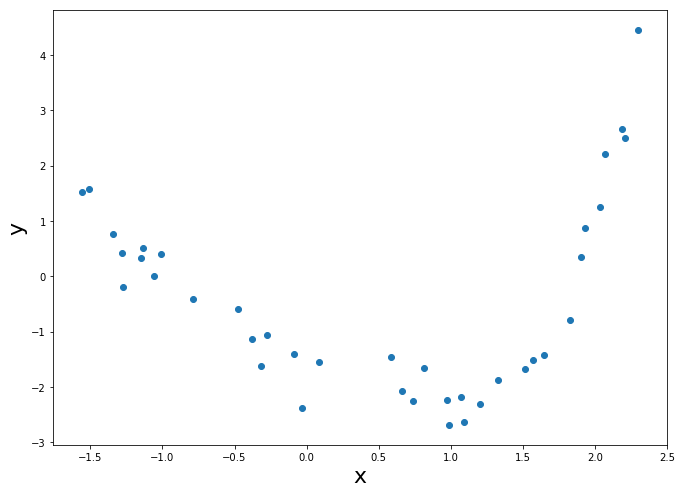

In [117]:
# Let's plot the points to see what they look like
plt.figure(figsize=(11, 8))
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.scatter(x,y)
plt.show()

For polynomial regression with order $p$, the first step is to formulate a matrix X with colums

$[\vec{x}, \vec{x}^1, \vec{x}^2, ..., \vec{x}^p$].

Then, our objective becomes

$\min_{\vec{\beta}} |\vec{y} - X\vec{\beta}|^2$.

Recall from lecture that, given the SVD decomposition of $X$ into {$U$, $S$, $V^T$}, the optimization objective reduces to

$\min_{\vec{\beta}} |\vec{y}^* - S\vec{\beta}^*|^2$

where $\vec{y}^* = U^T\vec{y}$ and $\vec{\beta}^* = V^T\vec{\beta}$.

The optimal $\beta$ (referred to as $\beta_{opt}$) is described as

$\vec{\beta}_{opt}^* = S^\#\vec{y}^*$

where $S^\#$ is a diagonal matrix with the shape of $S^T$ whose $m^{th}$ diagonal element is $\frac{1}{S_{mm}}$.

In [118]:
def svd(matrix):
    """
    A wrapper for numpy's SVD because numpy returns 
    singular values as an array (weird).
    """
    U, s, Vh = np.linalg.svd(matrix)
    S = np.zeros(matrix.shape, dtype=float)
    S[:len(s), :len(s)] = np.diag(s)
    return U, S, Vh

def sharp(S):
    """
    A function to convert S into S^# (S_sharp). S_sharp is a 
    diagonal matrix whose mth diagonal element is 1/S_mm. It
    has the shape of S^T.
    """
    S_sharp = np.zeros_like(S)
    n_row, n_col = S.shape
    for r in range(n_row):
        for c in range(n_col):
            if S[r,c] != 0:
                S_sharp[r,c] = 1/S[r,c]
    return S_sharp.T

def polynomial_regression(x, y, order):
    """
    A function to solve the polynomial least-squares regression
    problem for an arbitrary polynomial order.
    """
    # Create the matrix X by concatenating x column vectors of different orders
    cols = [np.power(x, i) for i in range(order+1)]
    X = np.hstack(cols)
    # Obtain SVD decomposition of X
    U, S, Vh = svd(X)
    # Compute B_opt_star
    y_star = np.matmul(U.T, y)
    S_sharp = sharp(S)
    B_opt_star = np.matmul(S_sharp, y_star)
    # Convert B_opt_star into B_opt by reversing the Vh transformation
    B_opt = np.matmul(Vh.T, B_opt_star)
    
    return B_opt

## Order 0

In [139]:
# we will hold B_opt for each order in a dictionary entry
B_opt = {}

In [141]:
B_opt[0] = polynomial_regression(x, y, order=0)

In [126]:
def plot_fit(x, y, B_opt):
    """
    A function to plot the fit for a given polynomial LS solution.
    """
    x_p = np.linspace(np.min(x), np.max(x), 30).reshape(-1, 1)
    y_p = 0
    for i, B in enumerate(B_opt):
        y_p += B*np.power(x_p, i)
    plt.figure(figsize=(11, 8))
    plt.xlabel('x', fontsize=22)
    plt.ylabel('y', fontsize=22)
    plt.scatter(x, y)
    plt.plot(x_p, y_p, color='r')
    plt.show()

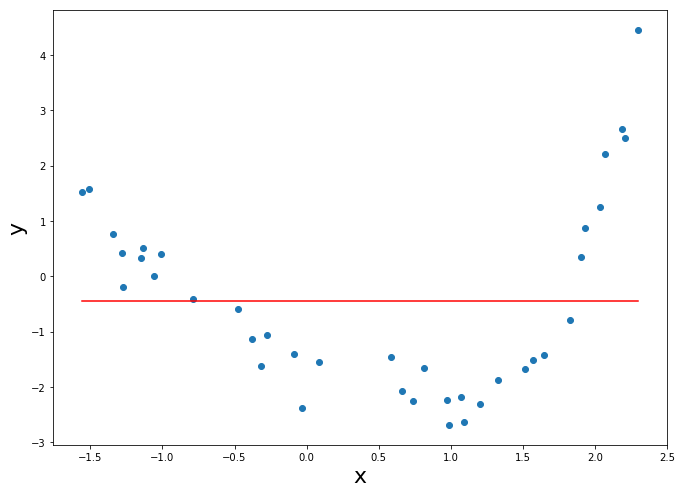

In [142]:
plot_fit(x, y, B_opt[0])

## Order 1

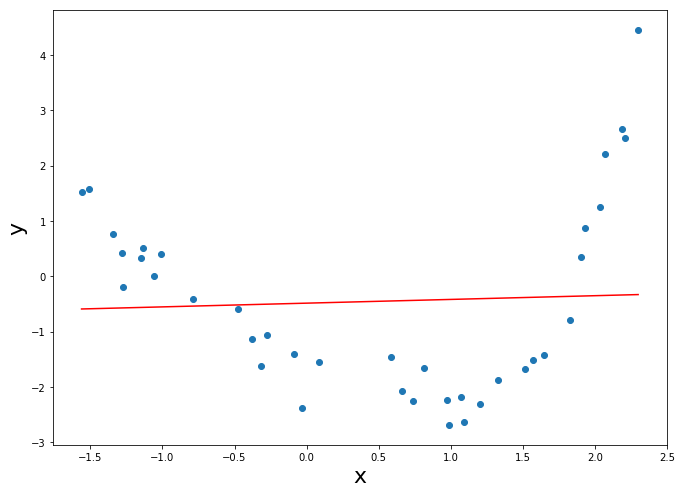

In [143]:
B_opt[1] = polynomial_regression(x, y, order=1)
plot_fit(x, y, B_opt[1])

## Order 2

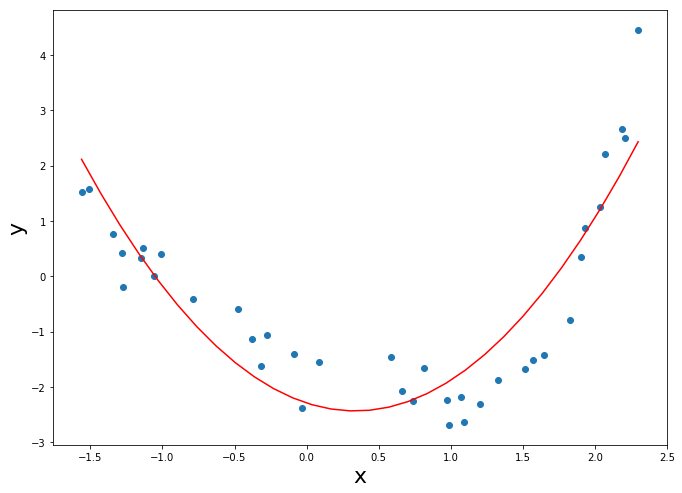

In [144]:
B_opt[2] = polynomial_regression(x, y, order=2)
plot_fit(x, y, B_opt[2])

## Order 3

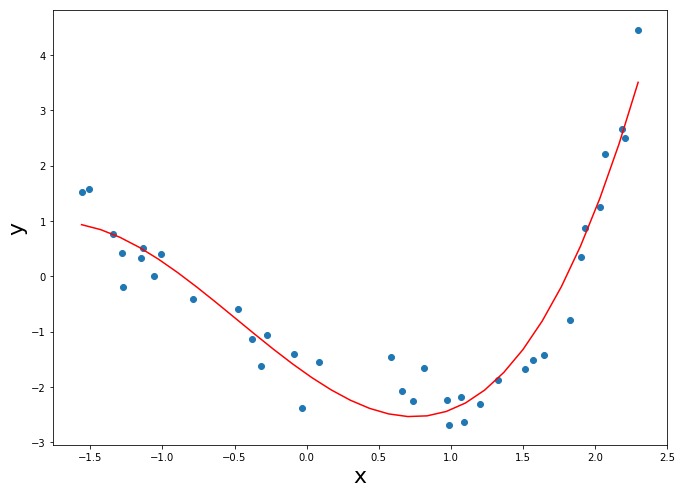

In [145]:
B_opt[3] = polynomial_regression(x, y, order=3)
plot_fit(x, y, B_opt[3])

## Order 4

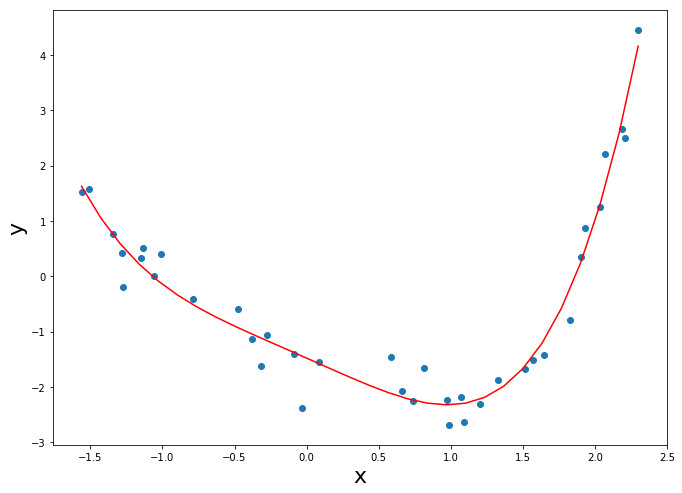

In [146]:
B_opt[4] = polynomial_regression(x, y, order=4)
plot_fit(x, y, B_opt[4])

## Order 5

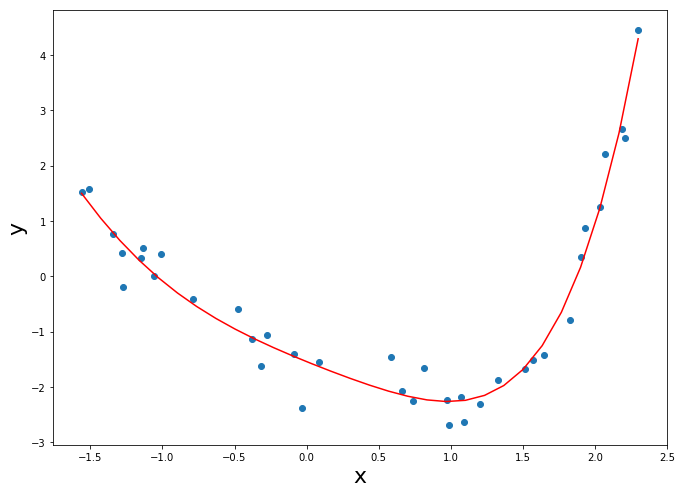

In [147]:
B_opt[5] = polynomial_regression(x, y, order=5)
plot_fit(x, y, B_opt[5])

## Error vs. Order plot

In [150]:
def compute_error(x, y, B_opt):
    y_p = 0
    for i, B in enumerate(B_opt):
        y_p += B*np.power(x, i)
    
    return np.sum(np.square(y - y_p))

orders = [elt for elt in range(6)]
errors = [compute_error(x, y, B_opt[i]) for i in orders]

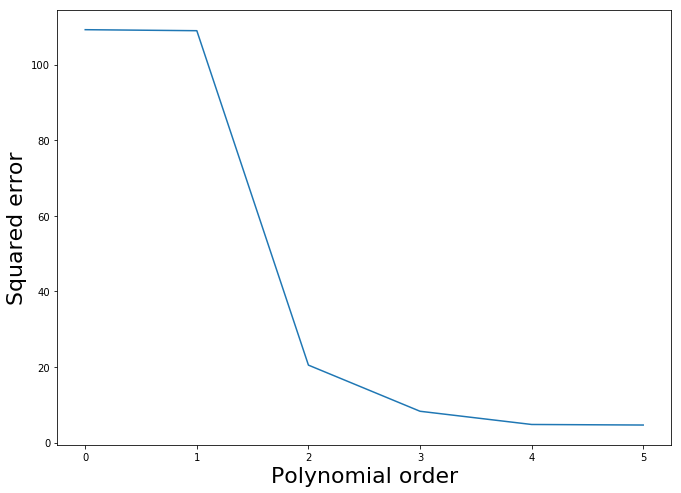

In [153]:
# Let's plot the errors vs order
plt.figure(figsize=(11, 8))
plt.xlabel('Polynomial order', fontsize=22)
plt.ylabel('Squared error', fontsize=22)
plt.plot(orders, errors)
plt.show()

I think that the fit with order=2 is the best. We know that the squared error for a higher order will always be less than or equal to that of lower order fits. But we don't want to increase the order so much that we overfit our data (i.e. have a model that is too complex). Order=2 looks like a good compromise here because it is the point where the slope of the error begins to flatten out, i.e. where the marginal benefit of adding an aditional order becomes negligible.

# Problem #3